# Практика по базовой математической статистике для Data scientist

# Практика 1 - анализ распределения случайной величины

- Генерация распределений - делаем синтетический датасет по заданным параметрам распределений (пара вариантов из непрерывных функций)
- Построение гистограммы распределения при помощи mathplotlib / seaborn.
- Анализ основных метрик распределения с помощью pandas и numpy - учимся делать выводы по оценкам случайной величины и форме распределения.

Для начала импортируем все полезные библитеки и настроим ноутбук

In [2]:
import matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sps
import warnings
from scipy.stats import kurtosis
from scipy.stats import skew

plt.rcParams["figure.figsize"] = (10.0, 7.0)
warnings.filterwarnings("ignore")

Пусть у нас будут два датасета - прибыль по клиентам разных групп, распределенные по нормальному закону N(500,1000) и Гамма закону, параметры которого будет необходимо вычислить на основе средней прибыли = 500 и среднеквадратическому отклонению = 1000.

Сгенерируем синтетические выборки размера ns = 10000 клиентов каждая.

In [11]:
ns = 10000
n_mean = 500
n_sigma = 1000

## Работаем с симметричным распределением

Используем имитацию нормального распределения отсюда
https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.normal.html

In [12]:
v = np.random.normal(n_mean, n_sigma, ns)
v = pd.DataFrame(v,columns = ["volume"])
v.volume = round(v.volume,0)
# start to generate not exist data

In [13]:
v.head(10)

,volume
0,634.0
1,-730.0
2,1406.0
3,-80.0
4,2628.0
5,1562.0
6,1172.0
7,377.0
8,618.0
9,855.0


Для оценки среднего, среднеквадратического отклонения и квантилей можно воспользоваться отдельными методами pandas и numpy

In [14]:
# Среднее
v.volume.mean()

486.8028

In [15]:
# Медиана
v.volume.median()

496.5

In [19]:
# Мода
v.volume.value_counts().nlargest(10)

-35.0      10
 900.0     10
 480.0     10
 12.0      10
 1138.0    10
 614.0     10
 436.0     10
 258.0      9
 1173.0     9
 500.0      9
Name: volume, dtype: int64

In [20]:
# Среднеквадратическое отклонение - далее ско
v.volume.std()

998.1827243482422

In [21]:
#  Квантиль - медиана
np.percentile(v.volume, 50)

496.5

In [22]:
# Кванталь - 0.75
np.percentile(v.volume, 75)

1156.0

Однако, удобнее воспользоваться встроенные методом pandas describe()

In [23]:
v.volume.describe()

count    10000.000000
mean       486.802800
std        998.182724
min      -3777.000000
25%       -183.000000
50%        496.500000
75%       1156.000000
max       4336.000000
Name: volume, dtype: float64

Здесь мы видим как среднее значение, так максимум, минимум, ско и все полезные квантили.

Теперь построим гистограмму распределения - сделаем это двумя способами, при помощи seaborn и встроенного метода pandas hist()

Text(0.5, 1.0, 'Распределение прибыли по пользователям группы 1')

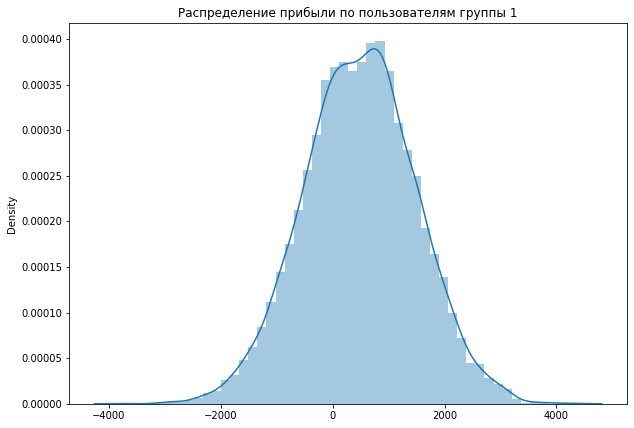

In [26]:
# При помощи seaborn
sns.distplot(v)
plt.title("Распределение прибыли по пользователям группы 1")

Text(0.5, 1.0, 'Распределение прибыли по пользователям группы 1')

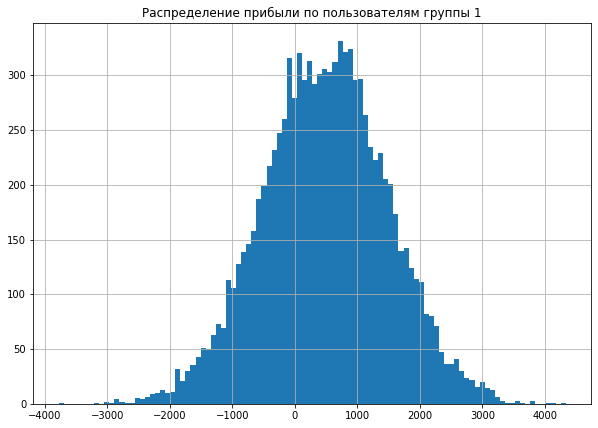

In [27]:
# При помощи pandas
v.volume.hist(bins = 100)
plt.title("Распределение прибыли по пользователям группы 1")

И не забудем про коэффициенты эксцесса и ассиметрии

In [20]:
# Эксцесс
kurtosis(v.volume)

0.06563817227244018

In [31]:
# Ассиметрия
skew(v.volume)

-0.031941914272988634

Теперь объединим все в одну функцию для удобства работы со вторй выборкой

In [28]:
def my_basic_research(df=v, column = "volume"):
    print("Базовые метрики")
    print(df[column].describe())
    print("------------------------------------")
    
    print("Самые популярные значения метрики, топ 5")
    print(df[column].value_counts().nlargest(5))
    print("------------------------------------")
    
    print("Эксцесс ", kurtosis(df[column]))
    print("Ассиметрия ", skew(df[column]))
    
    sns.distplot(df[column])
    plt.title("Распределение прибыли по пользователям")

Базовые метрики
count    10000.000000
mean       486.802800
std        998.182724
min      -3777.000000
25%       -183.000000
50%        496.500000
75%       1156.000000
max       4336.000000
Name: volume, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
-35.0      10
 900.0     10
 480.0     10
 12.0      10
 1138.0    10
Name: volume, dtype: int64
------------------------------------
Эксцесс  0.01722684267154495
Ассиметрия  -0.031941914272988634


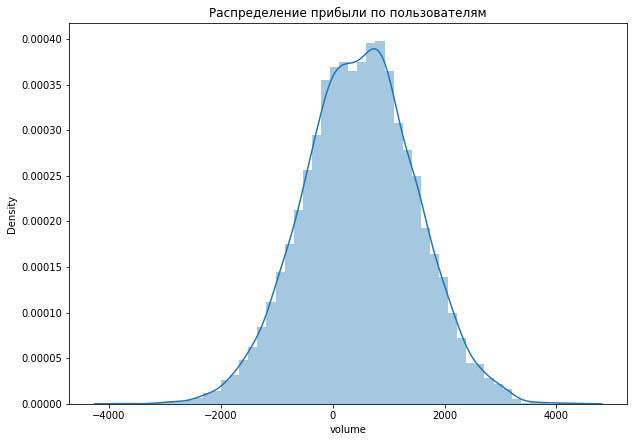

In [29]:
# Опробуем нашу функцию.
my_basic_research()

## Проверим на ассиметричном распределении

Вот так выглядит случай симметричных данных. Но в мире не все распределения симметричны - поэтому попробуем выяснить, чем это нам грозит, повторив анализ для Гамма распределения. Для начала подготовим датасет.

Параметры Гамма закона k и theta связаны со средним и дисперсией этого закона следующим образом (https://ru.wikipedia.org/wiki/Гамма-распределение):

$$m(x)=k*theta$$
$$D(x)=k*theta^2$$

Решая как систему уравнений, получим:

$$ k=(m(x)^2)/D(x)$$
$$theta=D(x)/m(x)$$

Зададим функцию для поиска параметров Гамма распределения по среднему и СКО

In [0]:
def gamma_params(mean, std):
    shape = round((mean/std)**2, 4)
    scale = round((std**2)/mean, 4)
    return (shape, scale)

In [0]:
shape, scale = gamma_params(n_mean, n_sigma)
df = np.random.gamma(shape, scale, ns)
df = pd.DataFrame(df,columns = ["volume"])

# Округлим до целых
df.volume = round(df.volume,0)

In [0]:
df.head()

,volume
0,707.0
1,0.0
2,1223.0
3,0.0
4,15.0


Базовые метрики
count    10000.000000
mean       518.284700
std       1048.956372
min          0.000000
25%          6.000000
50%         97.000000
75%        540.000000
max      18014.000000
Name: volume, dtype: float64
------------------------------------
Самые популярные значения метрики, топ 5
0.0    1336
1.0     453
2.0     245
3.0     177
6.0     127
Name: volume, dtype: int64
------------------------------------
Эксцесс  27.40347440191345
Ассиметрия  4.214029319719516


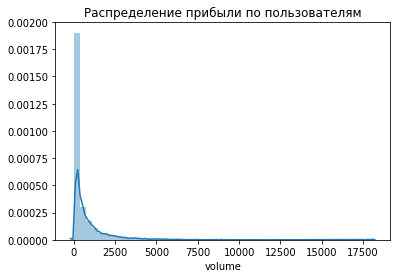

In [0]:
my_basic_research(df = df, column = "volume")

Как можно увидеть, теперь мы имеем дело а ассиметричным распределением и все квантили, а такде коэффициенты ассиметрии и эксцесса поменялись, несмотря на равенство средних и ско - и выводы по этим датасетам получаются абсолютно разные.

К примеру, сравним долю убыточных клиентов для первого и второго датасетов:

In [0]:
v[v.volume < 0].count()/len(v)

volume    0.3052
dtype: float64

In [0]:
df[df.volume < 0].count()/len(df)

volume    0.0
dtype: float64

А теперь сравним суммарную прибыль по клиентам с прибылью свыше медианы в млн:

In [0]:
v[v.volume >= np.percentile(v.volume,50)].volume.sum()/10**6

6.509022

In [0]:
df[df.volume >= np.percentile(df.volume,50)].volume.sum()/10**6

5.089377

Как можно видеть, эффект от ассимерии при одинаковых средних и ско существенно менять выводы.

## Мини домашка

Найдите медиану для Гамма распределения со средним = 1000 и среднеквадратичным отклонением = 3000, не округляя значения синтетического датасета.
Какое число получилось?